In [2]:
import numpy as np
import jax
from scipy.linalg import expm
import pennylane as qml
from pennylane import X, Y, Z
from functools import partial
import matplotlib.pyplot as plt

from pennylane.labs.dla import AI, cartan_decomp, cartan_subalgebra, check_cartan_decomp, variational_kak, validate_kak, op_to_adjvec, adjvec_to_op, check_all_commuting, orthonormalize, batched_pauli_decompose
from pennylane.labs.dla.cartan_subalgebra import _orthogonal_complement_basis

seed = 624
np.random.seed(seed)

In [3]:
from itertools import combinations, product
import numpy as np
import time
np.random.seed(2415)
from scipy.linalg import expm
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

import jax
jax.config.update("jax_enable_x64", True)

import pennylane as qml
from pennylane import X, Y, Z, I

from kak_tools import (
    map_simple_to_irrep,
    map_irrep_to_matrices,
    lie_closure_pauli_words,
    recursive_bdi,
    map_recursive_decomp_to_reducible,
    irrep_dot,
)

### Model

If we use the non-summed model:

$$
H = \sum_{i=1}^n h^x_i X_i X_{i+1} + h^y_i Y_i Y_{i+1} + h^z_i Z_i Z_{i+1} + \alpha_i Z_i
$$

If we use the summed model:

$$
H = \sum_{i=1}^n h_i \left(X_i X_{i+1} + Y_i Y_{i+1} + Z_i Z_{i+1}\right) + \alpha_i Z_i
$$

In [ ]:
generators

In [2]:
n = 6
summed_model = False
transverse_field = True
pbc = False
mu_h = 1.
sigma_h = 0.
mu_alpha = 0.5
sigma_alpha = 0.

tol = 1e-7


In [3]:
num_couplings = n if pbc else n-1

if summed_model==1:
    h = np.random.normal(mu_h, sigma_h, size=(num_couplings,))
elif summed_model==2:
    h = np.random.normal(mu_h, sigma_h, size=(num_couplings,)) #?
else:
    h = np.random.normal(mu_h, sigma_h, size=(3, num_couplings))

if transverse_field:
    alpha = np.random.normal(mu_alpha, sigma_alpha, size=(n,))

In [4]:
XX = [X(i) @ X((i+1)%n) for i in range(num_couplings)]
YY = [Y(i) @ Y((i+1)%n) for i in range(num_couplings)]
ZZ = [Z(i) @ Z((i+1)%n) for i in range(num_couplings)]
if summed_model==1:
    XXYY = [X(i) @ X((i+1)%n) + Y(i) @ Y((i+1)%n) for i in range(num_couplings)]
    H_XXYY = qml.dot(h, XXYY)
    H_XX = qml.dot(h, XX)
    H_YY = qml.dot(h, YY)
    H_ZZ = qml.dot(h, ZZ)
    if transverse_field:
        Zs = [Z(i) for i in range(n)]
        H_Z = qml.dot(alpha, Zs)
        ops = [op.pauli_rep for op in XXYY + Zs]
    else:
        ops = [op.pauli_rep for op in XXYY]
    
    H_trotter = qml.sum(H_XX, H_YY, H_ZZ+H_Z)
    H_sub = qml.sum(H_XXYY, H_Z, lazy=False)
    H_ext = H_ZZ
    H_full = H_sub + H_ext
elif summed_model==2:
    # XXYY = [X(i) @ X((i+1)%n) + Y(i) @ Y((i+1)%n) for i in range(num_couplings)]
    # H_XXYY = qml.dot(h, XXYY)
    H_XX = qml.dot(h, XX)
    H_YY = qml.dot(h, YY)
    H_ZZ = qml.dot(h, ZZ)
    if transverse_field:
        Zs = [Z(i) for i in range(n)]
        H_Z = qml.dot(alpha, Zs)
        ops = [op.pauli_rep for op in [H_XX, H_YY, H_Z]]
    else:
        ops = [op.pauli_rep for op in [H_XX, H_YY]]
    
    H_trotter = qml.sum(H_XX, H_YY, H_ZZ+H_Z)
    H_sub = qml.sum(H_XX, H_YY, H_Z, lazy=False)
    H_ext = H_ZZ
    H_full = H_sub + H_ext
else:
    XX = [X(i) @ X((i+1)%n) for i in range(num_couplings)]
    YY = [Y(i) @ Y((i+1)%n) for i in range(num_couplings)]
    ZZ = [Z(i) @ Z((i+1)%n) for i in range(num_couplings)]
    H_XX = qml.dot(h[0], XX)
    H_YY = qml.dot(h[1], YY)
    H_ZZ = qml.dot(h[2], ZZ)
    if transverse_field:
        Zs = [Z(i) for i in range(n)]
        H_Z = qml.dot(alpha, Zs)
        ops = [op.pauli_rep for op in XX + YY + Zs]
    else:
        ops = [op.pauli_rep for op in XX + YY]
        
    H_trotter = qml.sum(H_XX, H_YY, H_ZZ+H_Z)
    H_sub = qml.sum(H_XX, H_YY, H_Z, lazy=False)
    H_ext = H_ZZ
    H_full = H_sub + H_ext

assert len(H_trotter.operands) == 3
assert qml.equal(qml.simplify(H_trotter), qml.simplify(H_full))

In [5]:
def unitary_distance(U_0, U_1):
    assert U_0.shape[-2:] == U_1.shape[-2:]
    return 1 - np.abs(np.tensordot(U_0.conj(), U_1, axes=[[0, 1], [0, 1]])) / U_0.shape[-1]

def get_unitary_error(qnode, U_target):

    def wrapper(*args, **kwargs):
        mat = qml.matrix(qnode, wire_order=range(n))(*args, **kwargs)
        return unitary_distance(U_target, mat)

    return wrapper

def get_paulirot_count(qnode):

    def wrapper(*args, **kwargs):
        specs = qml.specs(qnode)(*args, **kwargs)
        gate_count = specs['resources'].num_gates
        gate_types = specs['resources'].gate_types
        assert len(gate_types) == 1, f"{gate_types}"
        assert list(gate_types)[0] == "PauliRot"
        assert list(gate_types.values())[0] == gate_count
        return gate_count
    return wrapper

def exp_as_pauli_rots(operand, time):
    """Implements exp(1j * time * operand) by implementing Pauli rotations.
    This is only valid if the Pauli words in the sentence commute, which is
    *not* certified by this function.
    """
    # for k, val in operand.pauli_rep.items():
    #     print("".join([k[key] for key in sorted(k.keys())]), sorted(k.keys()))
    return [qml.PauliRot(-2 * time * val, pauli_word="".join([k[key] for key in sorted(k.keys())]), wires=sorted(k.keys())) for k, val in operand.pauli_rep.items()]

In [6]:
dev = qml.device('default.qubit')

@qml.qnode(dev)
def trotter_circuit(operands, time, n, order):
    assert order==2

    for step in range(n):
        for operand in operands:
            exp_as_pauli_rots(operand, time / n / 2)
        for operand in operands[::-1]:
            exp_as_pauli_rots(operand, time / n / 2)
    return qml.probs(wires=0)


In [7]:
# print(qml.draw(trotter_circuit, max_length=250)(H_trotter.operands, -time, n=2, order=trotter_order))

In [18]:
use_paulirot = True

@qml.qnode(dev)
def subalgebra_circuit(csa_operand, other_operand, time, K_ansatz, K_params, n, k, use_paulirot=use_paulirot):
    assert k==2

    if use_paulirot:
        exp_as_pauli_rots(other_operand, -time / n / 2)
    else:
        qml.exp(-1j * time / (2*n) * other_operand)
    for step in range(n):
        K_ansatz(K_params)

        if use_paulirot:
            exp_as_pauli_rots(csa_operand, -time / n)
        else:
            qml.exp(-1j * time / n * csa_operand)
        qml.adjoint(K_ansatz, lazy=False)(K_params)
        if step == n-1:
            if use_paulirot:
                exp_as_pauli_rots(other_operand, -time / n / 2)
            else:
                qml.exp(-1j * time / (n * 2) * other_operand)
        else:
            if use_paulirot:
                exp_as_pauli_rots(other_operand, -time / n)
            else:
                qml.exp(-1j * time / n * other_operand)

    return qml.probs(wires=0)


In [19]:
g = qml.lie_closure(ops, pauli=True)
# print(H_sub.operands)
# print(len(g))
if cen:=qml.center(g):
    old_len_g = len(g)
    print(f"There is a center in this DLA: {cen}")
    g = adjvec_to_op(_orthogonal_complement_basis(op_to_adjvec(cen, g, is_orthogonal=False), op_to_adjvec(g, g, is_orthogonal=False), tol=tol), g, is_orthogonal=False)
    print(f"Removed center from algebra")
    assert len(g) == old_len_g - len(cen)
    assert not qml.center(g)
    H_center = sum(adjvec_to_op(op_to_adjvec([H_sub], cen, is_orthogonal=False), cen, is_orthogonal=False))
    H_sub = H_sub - H_center
    H_trotter = H_trotter - H_center
    H_full = H_full - H_center

print(n, len(g), 2 * (((2 * n) ** 2 - (2 * n)) // 2))
if summed_model==1:
    assert len(g) == n ** 2 - 1 # su(n)
elif summed_model==2 and np.isclose(sigma_alpha, 0.):
    assert len(g) == n**2 # so(n) + so(n)
elif summed_model==2 and not np.isclose(sigma_alpha, 0.):
    assert len(g) == ((2 * n) ** 2 - (2 * n)) // 2 # so(2n)
else:
    assert len(g) == ((2 * n) ** 2 - (2 * n)) // 2

k, m = cartan_decomposition(g, AI)
g = k + m
# print(g)
# print(k)
assert len(k) > 0 and len(m) > 0
assert check_cartan_decomp(k, m)

# Make sure H_sub is within m
[remapped_H_sub] = adjvec_to_op(op_to_adjvec([H_sub], m, is_orthogonal=False), m, is_orthogonal=False)
assert np.allclose(qml.matrix(H_sub, wire_order=range(n)), qml.matrix(remapped_H_sub, wire_order=range(n)))



if summed_model==1:
    manual_a = [Z(w) - Z(w+1) for w in range(n-1)]Skip to main panel
>
/devdevs/
Name
Modified

Selection deleted
import numpy as np
import pennylane as qml
from pennylane import X, Y, Z

from pennylane.labs.dla import AI, cartan_decomposition, variational_kak, check_cartan_decomp, op_to_adjvec, adjvec_to_op, check_all_commuting
from pennylane.labs.dla.cartan_subalgebra import _orthogonal_complement_basis
Last executed at 2024-11-21 11:20:34 in 5ms
Selection deleted
def check_subspace(sub, basis, n):
    if not isinstance(sub, (list, tuple)):
        sub = [sub]
    remapped = adjvec_to_op(op_to_adjvec(sub, basis, is_orthogonal=False), basis, is_orthogonal=False)
    for orig_op, remapped_op in zip(sub, remapped):
        if not np.allclose(qml.matrix(orig_op, wire_order=range(n)), qml.matrix(remapped_op, wire_order=range(n))):
            return False
    return True
Last executed at 2024-11-21 11:20:37 in 6ms

elif summed_model==2:
    adj = qml.structure_constants(g, is_orthogonal=False)
    g, k, mtilde, a, adj = cartan_subalgebra(g, k, m, adj)
    print(a)
    manual_a = a # No manual solution available
else:
    manual_a = [Z(w) for w in range(n)]


# Make sure manual_a is within m
remapped_a = adjvec_to_op(op_to_adjvec(manual_a, m, is_orthogonal=False), m, is_orthogonal=False)
for manual_op, remapped_op in zip(manual_a, remapped_a):
    assert np.allclose(qml.matrix(manual_op, wire_order=range(n)), qml.matrix(remapped_op, wire_order=range(n)))

manual_a = [op.pauli_rep for op in manual_a]
assert check_all_commuting(manual_a)
manual_a = orthonormalize(manual_a)

mtilde = adjvec_to_op(_orthogonal_complement_basis(op_to_adjvec(manual_a, g, is_orthogonal=False), op_to_adjvec(m, g, is_orthogonal=False), tol=tol), g, is_orthogonal=False)
g = k + mtilde + manual_a

from pennylane.labs.dla.dense_util import _gram_ps
print(f"Gram:\n{np.round(_gram_ps(g), 5)}")

adj = qml.structure_constants(g, is_orthogonal=False)
print(*manual_a, sep="\n"*2)
assert check_cartan_decomp(k, mtilde + manual_a)

6 66 132
Gram:
[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]
-1.0 * Z(0)

-1.0 * Z(1)

-1.0 * Z(2)

-1.0 * Z(3)

-1.0 * Z(4)

-1.0 * Z(5)


In [20]:
def test_adjoint_identity(adj, g, k, n, verbose=False):
    random_theta = np.random.random(len(k))
    random_coeffs = np.random.random(adj.shape[-1])
    
    [random_in] = adjvec_to_op(random_coeffs[None], g)
    random_in_m = qml.matrix(random_in, wire_order=range(n))
    if verbose:
        print(f"We will transform\n{random_in}\nby applying Ad_\exp(x) with x=\n{-1j * random_theta[0] * k[0]}")
    scale, *_ = k[0].values()
    if verbose:
        print(f"(Note cos(2 * theta * scale) = {np.cos(2 * random_theta[0] * scale)}")
        print(f"      sin(2 * theta * scale) = {np.sin(2 * random_theta[0] * scale)})")
    
    for i in range(len(k)):
        random_coeffs = jax.scipy.linalg.expm(random_theta[i] * adj[:, i]) @ random_coeffs
        break
    [random_out] = adjvec_to_op(random_coeffs[None], g)
    if verbose:
        print(f"With the adjoint representation we got out\n{random_out}")
    random_out_m = qml.matrix(random_out, wire_order=range(n))
    
    for i in range(len(k)):
        op_mat = k[i].operation().matrix(wire_order=range(n))
        exp_mat = jax.scipy.linalg.expm(1j * op_mat * random_theta[i])
        random_in_m = exp_mat @ random_in_m @ exp_mat.conj().T
        break
    random_in_m_op = pauli_decompose(random_in_m, pauli=True)
    if verbose:
        print(f"With the operator computation we got out\n{random_in_m_op}")
    assert np.allclose(random_out_m, random_in_m)

test_adjoint_identity(adj, g, k, n)

final loss: -926.707050362397; min loss: -926.7070503624096; after 0:01:25.509557


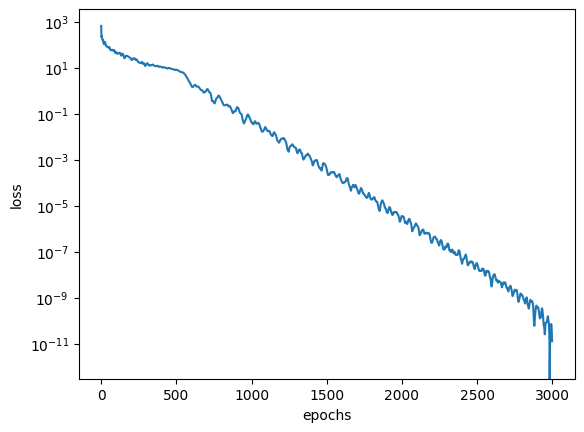

In [21]:
dims = (len(k), len(mtilde), len(manual_a))
assert sum(dims) == len(g)
kak_res = variational_kak(H_sub, g, dims, adj, verbose=2, opt_kwargs={"n_epochs": 3000}, pick_min=True)

In [22]:
assert validate_kak(H_sub, g, k, kak_res, n, tol)
vec_a, theta_opt = kak_res
vec_a = np.array(vec_a)
theta_opt = np.array(theta_opt)
assert np.allclose(vec_a[:-len(manual_a)], 0., atol=26*tol), f"In k:\n{vec_a[:len(k)]}\nIn mtilde:\n{vec_a[len(k):-len(manual_a)]}\nIn a:\n{vec_a[-len(manual_a):]}"

In [23]:
k_ops = [ps.operation() for ps in k]
k_pws = [
    (
        "".join([list(ps)[0][key] for key in sorted(list(ps)[0].keys())]),
        sorted(list(ps)[0].keys()),
        list(ps.values())[0],
    )
    for ps in k
]
# if use_paulirot:
    # assert all(len(ps)==1 for ps in k)

def K_ansatz(K_params, use_paulirot=use_paulirot):
    assert len(K_params) == len(k_ops) == len(k_pws)
    if use_paulirot:
        for par, op in zip(K_params[::-1], k_ops[::-1]):
            exp_as_pauli_rots(op, par)
        # for par, (pw, wires, pref) in zip(K_params[::-1], k_pws[::-1]):
        #     qml.PauliRot(-2 * pref * par, pw, wires=wires)
    else:
        for par, op in zip(K_params[::-1], k_ops[::-1]):
            qml.exp(1j * par * op)

csa_operand = qml.dot(vec_a[-len(manual_a):], manual_a)

In [24]:
# U_subalgebra = qml.matrix(subalgebra_circuit, wire_order=range(n))(csa_operand, H_ext, time, K_ansatz, theta_opt, trotter_steps, trotter_order)
# err_subalgebra = unitary_distance(U_subalgebra, U_target)
# print(f"Subalgebra technique using Trotter of order {trotter_order} with {trotter_steps} steps makes an error of {err_subalgebra:.6f}")

In [25]:
# Compute target exp(-iHt)
time = 0.7
U_target = expm(-1j * qml.matrix(H_full) * time)

In [30]:
print(qml.draw(subalgebra_circuit, max_length=170)(csa_operand, H_ext, time, K_ansatz, theta_opt, 2, 2))

0: ─╭RZZ(0.35)─────────────────────────────────────────────╭RYZZZZX(-4.28)─╭RXZZZZY(-1.93)────────────────────────────────────────────────────────────────────
1: ─╰RZZ(0.35)─╭RZZ(0.35)──────────────────────────────────├RYZZZZX(-4.28)─├RXZZZZY(-1.93)────────────────────────────╭RYZZZX(0.80)─╭RYZZX(-0.22)─╭RXZZY(3.44)
2: ────────────╰RZZ(0.35)─╭RZZ(0.35)───────────────────────├RYZZZZX(-4.28)─├RXZZZZY(-1.93)─╭RYZZX(-1.79)─╭RXZZY(1.82)─├RYZZZX(0.80)─├RYZZX(-0.22)─├RXZZY(3.44)
3: ───────────────────────╰RZZ(0.35)─╭RZZ(0.35)────────────├RYZZZZX(-4.28)─├RXZZZZY(-1.93)─├RYZZX(-1.79)─├RXZZY(1.82)─├RYZZZX(0.80)─├RYZZX(-0.22)─├RXZZY(3.44)
4: ──────────────────────────────────╰RZZ(0.35)─╭RZZ(0.35)─├RYZZZZX(-4.28)─├RXZZZZY(-1.93)─├RYZZX(-1.79)─├RXZZY(1.82)─├RYZZZX(0.80)─╰RYZZX(-0.22)─╰RXZZY(3.44)
5: ─────────────────────────────────────────────╰RZZ(0.35)─╰RYZZZZX(-4.28)─╰RXZZZZY(-1.93)─╰RYZZX(-1.79)─╰RXZZY(1.82)─╰RYZZZX(0.80)───────────────────────────

────────────────╭RYZZZX(0.19)─╭RYZZX(2.74)─╭R

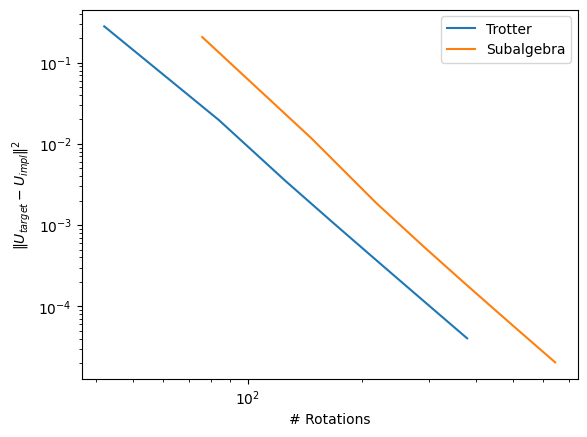

In [27]:
trotter_order = 2

all_trotter_steps_trotter = list(range(1, 10))
errors_trotter = []
rot_counts_trotter = []

for trotter_steps in all_trotter_steps_trotter:
    
    err_trotter = get_unitary_error(trotter_circuit, U_target)(H_trotter.operands, -time, n=trotter_steps, order=trotter_order)
    errors_trotter.append(err_trotter)
    rot_count_trotter = get_paulirot_count(trotter_circuit)(H_trotter.operands, -time, n=trotter_steps, order=trotter_order)
    rot_counts_trotter.append(rot_count_trotter)

all_trotter_steps_subalgebra = list(range(1, 10))
errors_subalgebra = []
rot_counts_subalgebra = []

for trotter_steps in all_trotter_steps_subalgebra:
    
    err_subalgebra = get_unitary_error(subalgebra_circuit, U_target)(csa_operand, H_ext, time, K_ansatz, theta_opt, trotter_steps, trotter_order)
    errors_subalgebra.append(err_subalgebra)
    rot_count_subalgebra = get_paulirot_count(subalgebra_circuit)(csa_operand, H_ext, time, K_ansatz, theta_opt, trotter_steps, trotter_order)
    rot_counts_subalgebra.append(rot_count_subalgebra)



fig, ax = plt.subplots()
ax.plot(rot_counts_trotter, errors_trotter, label="Trotter")
ax.plot(rot_counts_subalgebra, errors_subalgebra, label="Subalgebra")
ax.set_xlabel("# Rotations")
ax.set_ylabel("$\|U_{target}-U_{impl}\|^2$")
ax.set_xscale("log")
ax.set_yscale("log")
ax.legend()

In [28]:
# g_1 = qml.lie_closure(ops_sub)

# if pbc:
#     so_2n_dim = ((2 * n) ** 2 - (2 * n)) // 2
#     print(f"The small DLA has dimension {len(g_1)}. Dimension of so(2n) (+) so(2n): {2 * so_2n_dim}")
# else:
#     so_n_dim = ((n) ** 2 - (n)) // 2
#     print(f"The small DLA has dimension {len(g_1)}. Dimension of so(n) (+) so(n): {2 * so_n_dim}")

# print(((2 * n) ** 2 - (2 * n)) // 2)

In [ ]:
# [op for op in g_1 if all(all(v=="Z" for v in pw.values()) for pw in op.pauli_rep)]

In [ ]:
# def involution_AI(x):
#     """AI involution."""
#     if isinstance(x, np.ndarray):
#         return x.conj()
        
#     if is_ps:=isinstance(x, qml.pauli.PauliSentence):
#         ps = x
#     if isinstance(x, qml.operation.Operator):
#         if getattr(x, "pauli_rep", None) is not None:
#             ps = x.pauli_rep
#     ps.simplify()
#     new_ps = {}
#     for pw, val in ps.items():
#         num_y = sum(p == "Y" for p in pw.values())
#         new_ps[pw] = val * (-1)**(1 + num_y)
#     new_ps = qml.pauli.PauliSentence(new_ps)
#     if is_ps:
#         return new_ps
#     return new_ps.operation()
    
# assert qml.equal(involution_AI(H_sub), qml.simplify(-H_sub))
# assert qml.equal(involution_AI(H), qml.simplify(-H))

In [ ]:
# from pennylane.labs.dla import AI, cartan_decomposition

# k_1, m_1 = cartan_decomposition(g_1, AI)
# g_1_dec = k_1 + m_1

# so_n_dim = (n ** 2 - n) // 2
# print(f"Subalgebra has dimension {len(k_1)}. Dimension of [so(n) (+) so(n)] (+) [so(n) (+) so(n)]: {4 * so_n_dim}")

In [ ]:
# from pennylane.labs.dla import cartan_subalgebra

# adj = qml.structure_constants(g_1_dec)
# g_1_dec, k_1, mtilde_1, a_1, adj = cartan_subalgebra(g_1_dec, k_1, m_1, adj)
# print(len(a_1))

In [ ]:
# from pennylane.labs.dla import variational_kak

# dims = (len(k_1), len(mtilde_1), len(a_1))
# vec_a, theta_opt = variational_kak(H_sub, g_1_dec, dims, adj, verbose=2, opt_kwargs={"n_epochs": 3000}, pick_min=True)


In [ ]:
# g_min = qml.lie_closure(ops_sub + ops_ext[:1])
# print(len(g_min))
# g_max = qml.lie_closure(ops_sub + ops_ext)
# print(len(g_max))
# print(2*(4**(n-1)-1)) # su(n-1) (+) su(n-1)  with transverse field
# print((4**(n-1)-1)) # su(n-1) without transverse field odd n
# print(4 * (4**(n-2)-1)) # su(n-1) (+) su(n-1) (+) su(n-1) (+) su(n-1) without transverse field even n

In [ ]:
# idx = 14
# import matplotlib.pyplot as plt

# g = g_max
# adj = qml.structure_constants(g)

# ncol = 5
# fig, axs = plt.subplots(int(np.ceil(len(g)/ncol)), ncol, figsize=(15, 15))

# seps = [8, 16]

# for idx in range(len(g)):
#     idx_row = idx // ncol
#     idx_col = idx % ncol
#     ax = axs[idx_row, idx_col]
#     ax.imshow(adj[:, idx], cmap="PiYG")
#     for sep in seps:
#         ax.plot([sep-0.5] * 2, [-0.5, len(g)-0.5], c="k", lw=0.5)
#         ax.plot([-0.5, len(g)-0.5], [sep-0.5] * 2, c="k", lw=0.5)

In [ ]:
# maxs = []
# for n in range(2, 12):
#     pbc = False
#     transverse_field = True
#     num_couplings = n if pbc else n-1
    
#     h = np.ones((2, num_couplings))
#     alpha = np.ones(n)
    
#     ops_sub = [X(i) @ X((i+1)%n) for i in range(num_couplings)] + [Y(i) @ Y((i+1)%n) for i in range(num_couplings)]
#     if transverse_field:
#         ops_sub += [Z(i) for i in range(n)]
#     # ops_ext = [Z(i) @ Z((i+1)%n) for i in range(num_couplings)]
#     if transverse_field:
#         H_sub = qml.dot(np.concatenate([h[0], h[1], alpha]), ops_sub)
#     else:
#         H_sub = qml.dot(np.concatenate([h[0], h[1]]), ops_sub)
#     # H_ext = qml.dot(h[2], ops_ext)
#     # H = H_sub + H_ext
#     eigvals = qml.eigvals(H_sub)
#     print(f"{n=}: {np.min(eigvals)}     {np.max(eigvals)/n}")
#     maxs.append(np.max(eigvals)/n)

In [ ]:
# plt.plot(maxs)